In [28]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import time
import torch.optim as optim
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import torchvision.utils as vutils
from torch.autograd import Variable
from torch import autograd



# New Section

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
pip install idx2numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
########### import_data ############
import idx2numpy

def import_data(imageFile,labelsFile):
    data = idx2numpy.convert_from_file(imageFile)
    # arr is a np.ndarray type of object of shape (60000, 28, 28)
    labels = idx2numpy.convert_from_file(labelsFile)
    # labels is a np.ndarray type of object of shape (60000, )
    data = (torch.tensor(data).float() - 128)/128
    #normalises the data to the interval [-1,1]
    labels = torch.tensor(labels).float()

    dataShape = torch.reshape(data,(-1,1,28,28))
    # We reshape to allow for a channel "1" which makes working with the convolution functions later easier
    #print(data[0,:,:])
    return dataShape, labels

def generate_random_image_data(n):

    imageArray = np.random.randint(0,256,size = (n,1,28,28))

    return torch.tensor(imageArray).float()


In [32]:
####### View Data #############
def plot_single_sample(data,label):

    plt.figure()
    plt.imshow(data, cmap = 'gray')
    plt.title(str(label))
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    plt.show()

def plot_single_sample_incorrect_label(data,label,networkLabel):

    plt.figure()
    plt.imshow(data, cmap = 'gray')
    plt.title('Truth: ' + str(label) + ', Model label: ' + str(networkLabel))
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    plt.show()

def plot_multiple_samples(data,labels,n):
    m = len(n)
    fig, axes = plt.subplots(ncols = m,sharex=False, sharey=True, figsize=(10, 4))
    for i in range(m):
        label = int(labels[n[i]])
        axes[i].set_title(label)
        axes[i].imshow(data[n[i],:,:], cmap='gray')
        axes[i].get_xaxis().set_visible(False)
        axes[i].get_yaxis().set_visible(False)
        
    plt.show()

def plot_multiple_samples_incorrect_label(data):
    m = len(data)
    fig, axes = plt.subplots(ncols = m,sharex=False, sharey=True, figsize=(10, 4))
    for i in range(m):
#        data[i,0,:,:], number, modelOutput])
        label = 'Truth: ' + str(data[i][1]) + '\nModel label: ' + str(data[i][2])
        axes[i].set_title(label)
        axes[i].imshow(data[i][0], cmap='gray')
        axes[i].get_xaxis().set_visible(False)
        axes[i].get_yaxis().set_visible(False)
        
    plt.show()

In [33]:
############ Network Definitions ################

class Generator(nn.Module):
    
    def __init__(self,nLatent):
        super(Generator, self).__init__()

        self.nLatent = nLatent
        self. z_dim = 100
        self.conv1 = self.get_generator_block(self.z_dim, nLatent * 4, kernel_size=3, stride=2)
        self.conv2 = self.get_generator_block(nLatent * 4, nLatent * 2, kernel_size=4, stride = 1)
        self.conv3 = self.get_generator_block(nLatent * 2, nLatent, kernel_size=3, stride = 2)
        self.convFinal = self.get_generator_final_block(nLatent, 1, kernel_size=4, stride=2)


    def get_generator_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channel),
                nn.LeakyReLU(0.2,inplace=True),
        )    

    def get_generator_final_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return  nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.Tanh()
            )
    
    def forward(self, noise): 
        x = noise.view(len(noise), self.z_dim, 1, 1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.convFinal(x)
        return x
    
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        imChannel = 1
        hiddenDimension = 16

        self.disc = nn.Sequential(            
            self.get_critic_block(imChannel, hiddenDimension * 4, kernel_size=4, stride=2),
            self.get_critic_block(hiddenDimension * 4, hiddenDimension * 8, kernel_size=4, stride=2,),
            self.get_critic_final_block(hiddenDimension * 8, 1, kernel_size=4, stride=2,),
        )

    def get_critic_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 2):
        return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.LeakyReLU(0.2, inplace=True)
        )
    
    def get_critic_final_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return  nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride, padding),
            )
    
    def forward(self, image):
        return self.disc(image)



def compute_gp(netD, real_data, fake_data):
        batch_size = real_data.size(0)
        # Sample Epsilon from uniform distribution
        eps = torch.rand(batch_size, 1, 1, 1).to(real_data.device)
        eps = eps.expand_as(real_data)
        
        # Interpolation between real data and fake data.
        interpolation = eps * real_data + (1 - eps) * fake_data
        
        # get logits for interpolated images
        interp_logits = netD(interpolation)
        grad_outputs = torch.ones_like(interp_logits)
        
        # Compute Gradients
        gradients = autograd.grad(
            outputs=interp_logits,
            inputs=interpolation,
            grad_outputs=grad_outputs,
            create_graph=True,
            retain_graph=True,
        )[0]
        
        # Compute and return Gradient Norm
        gradients = gradients.view(batch_size, -1)
        grad_norm = gradients.norm(2, 1)
        return torch.mean((grad_norm - 1) ** 2)

In [34]:
###### Plotting and saving ############

def plotGeneratedImageArray():
    plt.figure(figsize = (8,8))
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(imageList[-1],(1,2,0)))
    plt.show() 

def saveModelFunct():
    torch.save({
        #'epoch': epochs[-1],
        'model_state_dict': generator.state_dict(),
        'optimizer_state_dict': optimiserG.state_dict(),
        'loss': lossesG,
        'images': imageList
            }, generatorFile)
    print('Model saved as "' + generatorFile + '"')

    torch.save({
        #'epoch': epochs[-1],
        'model_state_dict': discriminator.state_dict(),
        'optimizer_state_dict': optimiserD.state_dict(),
        'loss': lossesD,
            }, discriminatorFile)
    print('Model saved as "' + discriminatorFile + '"')

def plotLearningRateGraph():
    plt.figure()
    maxD = 1#abs(max(lossesD,key = abs))
    plt.plot([x/maxD for x in lossesD], label = 'Discriminator')
    maxG = 1#abs(max(lossesG,key = abs))
    plt.plot([x/maxG for x in lossesG], label = 'Generator')
    plt.legend()
    plt.grid()
    plt.xlabel('Model Steps')
    plt.ylabel('Loss (Normalised)')
    plt.show()

def loadFiles(generator, discriminator, lossesD, lossesG, imageList, discriminatorFile, generatorFile):

  discriminator = Discriminator().to(device)
  generator = Generator(nGeneratorIn).to(device)
  if exists(discriminatorFile):
      checkpoint = torch.load(discriminatorFile, map_location = torch.device(device))
      discriminator.load_state_dict(checkpoint['model_state_dict'])
      optimiserD.load_state_dict(checkpoint['optimizer_state_dict'])
      #lossesG.load_state_dict(checkpoint['lossG'])
      #imageList.load_state_dict(checkpoint['imageList'])
      print('Loaded model at ' + discriminatorFile)

  if exists(generatorFile):
      checkpoint = torch.load(generatorFile, map_location = torch.device(device))
      generator.load_state_dict(checkpoint['model_state_dict'])
      optimiserG.load_state_dict(checkpoint['optimizer_state_dict'])
      #lossesG.load_state_dict(checkpoint['lossG'])
      print('Loaded model at ' + generatorFile)

  return  generator, discriminator, lossesD, lossesG, imageList


In [35]:
######## Main backprop algorithm ##########

def runBackpropogation(epochs,steps,step,imageList,lossesG,lossesD,clipping,nBatch,nCritic,lamdaGP,plotLearningRate,workers):
  for epoch in range(epochs):
    epochStartTime = time.time()
    for i, data in enumerate(dataloader, 0):
        data=data.to(device)
        #print(i)
        steps.append(step)
        step += 1
        for j in range(nCritic):
        ############ Train discriminator #############
            optimiserD.zero_grad()

            # all real
            discriminatorPredictionReal = discriminator(data)
            meanPredReal = torch.mean(discriminatorPredictionReal)
            # all fake
            noise = torch.randn(nBatch, nGeneratorIn, 1, 1, device=device)
            generatedDigits = generator.forward(noise)
            discriminatorPredictionFake = discriminator(generatedDigits)
            meanPredFake = torch.mean(discriminatorPredictionFake)
            # calculate loss. This gets higher the better the discriminator is
            discriminatorLoss = - meanPredReal + meanPredFake + lamdaGP * compute_gp(discriminator,data,generatedDigits)
            discriminatorLoss.backward()
            # step
            optimiserD.step()

        ############ Train Generator ##############
        optimiserG.zero_grad()
        # Since we just updated discriminator, perform another forward pass of all-fake batch through D
        output = discriminator(generator(noise))
        # Calculate generator loss based on this output
        generatorError = -torch.mean(output)
        # Calculate gradients for generator
        generatorError.backward()            
        # Update generator
        optimiserG.step()
        meanYGenerator = output.mean().item()

        lossesD.append(discriminatorLoss.item())
        lossesG.append(generatorError.item())
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
              % (epoch, epochs, i, len(dataloader),
                  discriminatorLoss.item(), generatorError.item(), meanPredReal, meanPredFake, meanYGenerator))
    
        if (step % 300 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
                imageList.append(vutils.make_grid(fake, padding=2, normalize=True))

    if plotGeneratedImages and len(imageList) >0:
      # plots output every epoch
      plt.figure(figsize = (8,8))
      plt.axis("off")
      plt.title("Fake Images")
      plt.imshow(np.transpose(imageList[-1],(1,2,0)))
      plt.show()  
    delT = time.time() - epochStartTime
    print("Epoch took " + str(round(delT)) + "s.")
  return steps, imageList, lossesG, lossesD, step

In [36]:
####### setup new labels and models ############
fileFolder = '/content/drive/MyDrive/Colab Notebooks/train_GAN_files'

trainingFiles = [fileFolder + '/train-images-idx3-ubyte',fileFolder + '/train-labels-idx1-ubyte']
testFiles = [fileFolder + '/train-images-idx3-ubyte',fileFolder + '/train-labels-idx1-ubyte']
generatorFile = fileFolder + '/generator.pt'
discriminatorFile = fileFolder + '/discriminator.pt'

loadModel = False
saveModel = True
plotGeneratedImages = True
plotSingleSample = True

realData,numbers = import_data(trainingFiles[0],trainingFiles[1])
nGeneratorIn = 100

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
#realData, numbers = realData.to(device), numbers.to(device)

discriminator = Discriminator().to(device)
generator = Generator(nGeneratorIn).to(device)

lossesG = []
lossesD = []
imageList = []
fixed_noise = torch.randn(64, nGeneratorIn, 1, 1, device=device)
steps = []
step = 0

Using cuda device


In [37]:
####### sets up variables which may be changed at runtime ########
epochs = 5
MNISTSubset = 60000
beta_1 = 0.5 
beta_2 = 0.999
# https://arxiv.org/pdf/1701.07875.pdf Wasserstein paper for source of values
learningRate = 0.00005
nBatch = 128
nCritic = 5 # number of generations of the critic per generator iteration
lamdaGP = 5 # https://arxiv.org/pdf/1704.00028.pdf
plotLearningRate = True
workers = 2

# In case we want to run with a subset of the data. The last batch is dropped if the remaining data is smaller than nBatch
dataloader = torch.utils.data.DataLoader(realData[0:MNISTSubset,:,:,:], batch_size=nBatch, shuffle=True, num_workers=workers, drop_last=True)

#print(generator.forward(torch.randn(1, nGeneratorIn, 1, 1, device=device))[0,0,:,:])
#print(realData[0,0,:,:])
# Setup Adam optimizers for each network
optimiserD = optim.Adam(discriminator.parameters(), lr=learningRate, betas=(beta_1, beta_2))
optimiserG = optim.Adam(generator.parameters(), lr=learningRate, betas=(beta_1, beta_2))


[0/5][0/468]	Loss_D: 2.2893	Loss_G: 0.0079	D(x): 0.1617	D(G(z)): -0.0051 / -0.0079
[0/5][50/468]	Loss_D: -1.3406	Loss_G: -0.0458	D(x): 1.4506	D(G(z)): 0.0558 / 0.0458
[0/5][100/468]	Loss_D: -1.3290	Loss_G: 0.2419	D(x): 1.1578	D(G(z)): -0.2484 / -0.2419
[0/5][150/468]	Loss_D: -1.2591	Loss_G: 0.0237	D(x): 1.2882	D(G(z)): -0.0259 / -0.0237
[0/5][200/468]	Loss_D: -1.1349	Loss_G: -0.0678	D(x): 1.2612	D(G(z)): 0.0658 / 0.0678
[0/5][250/468]	Loss_D: -1.0282	Loss_G: -0.0965	D(x): 1.1847	D(G(z)): 0.1061 / 0.0965
[0/5][300/468]	Loss_D: -1.0000	Loss_G: 0.0791	D(x): 0.9607	D(G(z)): -0.0853 / -0.0791
[0/5][350/468]	Loss_D: -1.0039	Loss_G: 0.0119	D(x): 1.0510	D(G(z)): -0.0041 / -0.0119
[0/5][400/468]	Loss_D: -1.0322	Loss_G: -0.0085	D(x): 1.0860	D(G(z)): 0.0025 / 0.0085
[0/5][450/468]	Loss_D: -1.0477	Loss_G: 0.0346	D(x): 1.0709	D(G(z)): -0.0336 / -0.0346


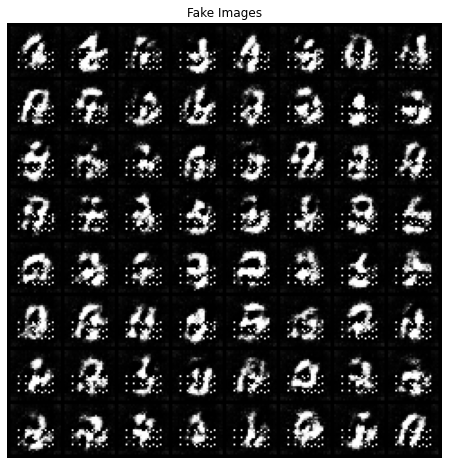

Epoch took 82s.
[1/5][0/468]	Loss_D: -1.0478	Loss_G: -0.0350	D(x): 1.1820	D(G(z)): 0.0749 / 0.0350
[1/5][50/468]	Loss_D: -1.0442	Loss_G: -0.0689	D(x): 1.1866	D(G(z)): 0.0949 / 0.0689
[1/5][100/468]	Loss_D: -1.0234	Loss_G: 0.0842	D(x): 1.0170	D(G(z)): -0.0584 / -0.0842
[1/5][150/468]	Loss_D: -1.0484	Loss_G: 0.0538	D(x): 0.9758	D(G(z)): -0.1191 / -0.0538
[1/5][200/468]	Loss_D: -1.0530	Loss_G: 0.1431	D(x): 0.9510	D(G(z)): -0.1509 / -0.1431
[1/5][250/468]	Loss_D: -1.0491	Loss_G: 0.1398	D(x): 0.9945	D(G(z)): -0.1132 / -0.1398
[1/5][300/468]	Loss_D: -1.0724	Loss_G: 0.1713	D(x): 0.9677	D(G(z)): -0.1628 / -0.1713
[1/5][350/468]	Loss_D: -1.0532	Loss_G: 0.2208	D(x): 0.8482	D(G(z)): -0.2611 / -0.2208
[1/5][400/468]	Loss_D: -1.0360	Loss_G: 0.3047	D(x): 0.7432	D(G(z)): -0.3446 / -0.3047
[1/5][450/468]	Loss_D: -1.0569	Loss_G: 0.3129	D(x): 0.7962	D(G(z)): -0.3154 / -0.3129


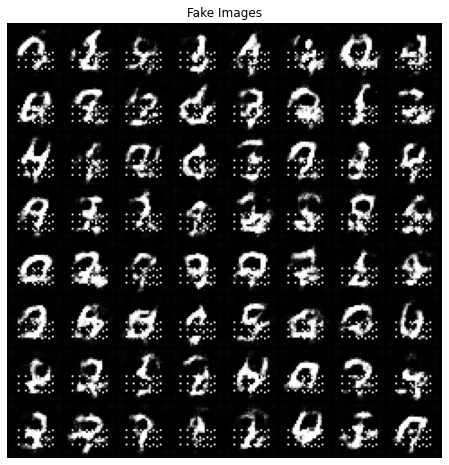

Epoch took 80s.
[2/5][0/468]	Loss_D: -1.0505	Loss_G: 0.2818	D(x): 0.8365	D(G(z)): -0.2750 / -0.2818
[2/5][50/468]	Loss_D: -1.0344	Loss_G: 0.3391	D(x): 0.7163	D(G(z)): -0.3729 / -0.3391
[2/5][100/468]	Loss_D: -1.0504	Loss_G: 0.3668	D(x): 0.7368	D(G(z)): -0.3662 / -0.3668
[2/5][150/468]	Loss_D: -0.7063	Loss_G: -0.2657	D(x): 1.0421	D(G(z)): 0.3062 / 0.2657
[2/5][200/468]	Loss_D: -0.6201	Loss_G: -0.1091	D(x): 0.8027	D(G(z)): 0.1565 / 0.1091
[2/5][250/468]	Loss_D: -0.5939	Loss_G: 0.0338	D(x): 0.6234	D(G(z)): 0.0104 / -0.0338
[2/5][300/468]	Loss_D: -0.2279	Loss_G: -0.6616	D(x): 0.9259	D(G(z)): 0.6880 / 0.6616
[2/5][350/468]	Loss_D: -0.2370	Loss_G: 0.0451	D(x): 0.2120	D(G(z)): -0.0393 / -0.0451
[2/5][400/468]	Loss_D: -0.1607	Loss_G: -0.2315	D(x): 0.4823	D(G(z)): 0.3112 / 0.2315
[2/5][450/468]	Loss_D: -0.1734	Loss_G: -0.2007	D(x): 0.4141	D(G(z)): 0.2219 / 0.2007


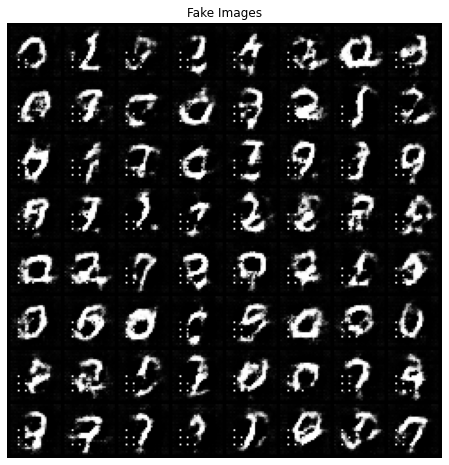

Epoch took 80s.
[3/5][0/468]	Loss_D: -0.1761	Loss_G: 0.1447	D(x): 0.0142	D(G(z)): -0.1787 / -0.1447
[3/5][50/468]	Loss_D: -0.1532	Loss_G: -0.2162	D(x): 0.4012	D(G(z)): 0.2367 / 0.2162
[3/5][100/468]	Loss_D: -0.1600	Loss_G: -0.0329	D(x): 0.3425	D(G(z)): 0.1709 / 0.0329
[3/5][150/468]	Loss_D: -0.1656	Loss_G: 0.0731	D(x): 0.1113	D(G(z)): -0.0688 / -0.0731
[3/5][200/468]	Loss_D: -0.1958	Loss_G: 0.2578	D(x): -0.1099	D(G(z)): -0.3280 / -0.2578
[3/5][250/468]	Loss_D: -0.1912	Loss_G: 0.4508	D(x): -0.2471	D(G(z)): -0.4547 / -0.4508
[3/5][300/468]	Loss_D: -0.1722	Loss_G: -0.0737	D(x): 0.1157	D(G(z)): -0.0698 / 0.0737
[3/5][350/468]	Loss_D: -0.1611	Loss_G: -0.2328	D(x): 0.3332	D(G(z)): 0.1619 / 0.2328
[3/5][400/468]	Loss_D: -0.1596	Loss_G: -0.1318	D(x): 0.2718	D(G(z)): 0.1006 / 0.1318
[3/5][450/468]	Loss_D: -0.1423	Loss_G: -0.3139	D(x): 0.4070	D(G(z)): 0.2522 / 0.3139


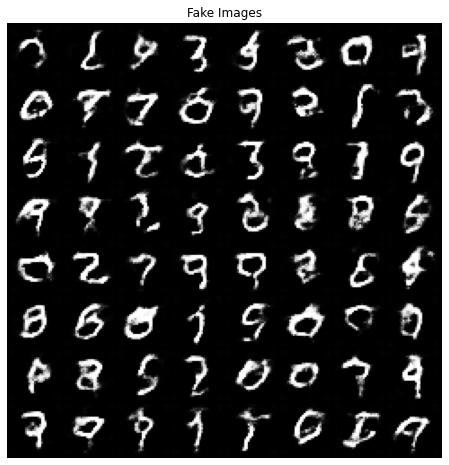

Epoch took 80s.
[4/5][0/468]	Loss_D: -0.1273	Loss_G: 0.1741	D(x): 0.0039	D(G(z)): -0.1334 / -0.1741
[4/5][50/468]	Loss_D: -0.1358	Loss_G: 0.0076	D(x): 0.1612	D(G(z)): 0.0137 / -0.0076
[4/5][100/468]	Loss_D: -0.1410	Loss_G: 0.1375	D(x): 0.1151	D(G(z)): -0.0394 / -0.1375
[4/5][150/468]	Loss_D: -0.1322	Loss_G: 0.0181	D(x): 0.3198	D(G(z)): 0.1756 / -0.0181
[4/5][200/468]	Loss_D: -0.1244	Loss_G: -0.0183	D(x): 0.1365	D(G(z)): 0.0006 / 0.0183
[4/5][250/468]	Loss_D: -0.1552	Loss_G: 0.4587	D(x): -0.3518	D(G(z)): -0.5256 / -0.4587
[4/5][300/468]	Loss_D: -0.1154	Loss_G: 0.0592	D(x): 0.2271	D(G(z)): 0.0982 / -0.0592
[4/5][350/468]	Loss_D: -0.1286	Loss_G: 0.3377	D(x): -0.1836	D(G(z)): -0.3250 / -0.3377
[4/5][400/468]	Loss_D: -0.1043	Loss_G: -0.2350	D(x): 0.3099	D(G(z)): 0.1954 / 0.2350
[4/5][450/468]	Loss_D: -0.1070	Loss_G: 0.0876	D(x): 0.0245	D(G(z)): -0.0905 / -0.0876


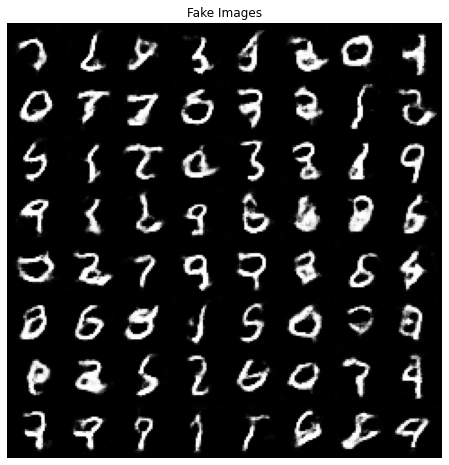

Epoch took 80s.
Model saved as "/content/drive/MyDrive/Colab Notebooks/train_GAN_files/generator.pt"
Model saved as "/content/drive/MyDrive/Colab Notebooks/train_GAN_files/discriminator.pt"


In [24]:
#### run model #######

if loadModel:
  generator, discriminator, lossesD, lossesG, imageList = loadFiles(generator, discriminator, lossesD, lossesG, imageList, discriminatorFile, generatorFile)

steps, imageList, lossesG, lossesD, step = runBackpropogation(epochs,steps,step,imageList,lossesG,lossesD,clipping,nBatch,nCritic,lamdaGP,plotLearningRate,workers)

if saveModel:
  saveModelFunct()
  

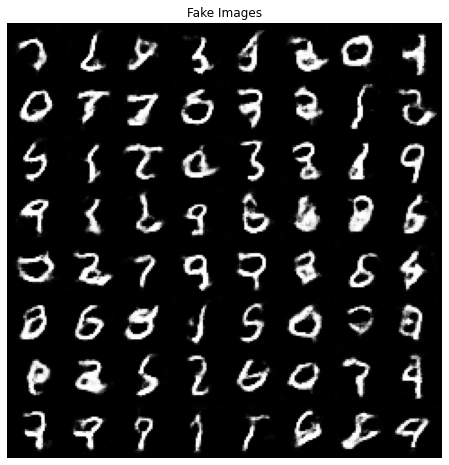

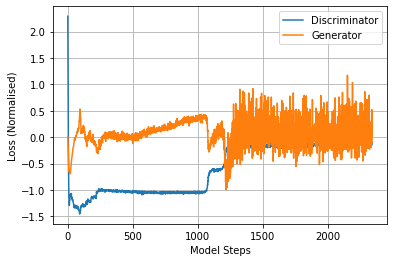

In [25]:
########## some useful plots #########

def plotLearningRateGraphEdited():
    plt.figure()
    maxD = abs(max(lossesD,key = abs))
    plt.plot([x/maxD for x in lossesD], label = 'Discriminator')
    maxG = abs(max(lossesG,key = abs))
    plt.plot([x/maxG for x in lossesG], label = 'Generator')
    plt.legend()
    plt.ylim([-1,1])
    plt.grid()
    plt.xlabel('Model Steps')
    plt.ylabel('Loss (Normalised)')
    plt.show()


if plotGeneratedImages:
  plotGeneratedImageArray() 

if plotSingleSample and False:  
    plot_single_sample(generator.forward(torch.randn(1, nGeneratorIn, 1, 1, device=device)).detach()[0,0,:,:].cpu(),"Generated Sample")



if plotLearningRate:
  plotLearningRateGraph()
  #plotLearningRateGraphEdited()



8


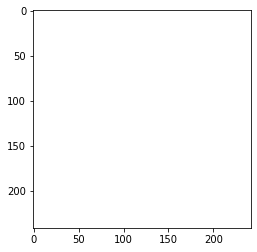

In [26]:
######### animation #########
from matplotlib import rc
rc('animation', html='jshtml')

import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()

print(len(imageList))
smallerList = imageList[0::5]
frames = [[ax.imshow(smallerList[i].permute(1,2,0))] for i in range(len(smallerList))]
#permutes the image to the right orientation for matplotlib. ie ChannelxHxW to HxWxChannel.
# Channel is 1 in this case of grayscale

ani = animation.ArtistAnimation(fig, frames)
ani

In [27]:
######## save animation to file ###########

f = fileFolder + '/animation_padding.gif'
writergif = animation.PillowWriter(fps=15) 
ani.save(f, writer=writergif)